# PUC Minas EAD - Trabalho de conclusão de curso

Trabalho de conclusão de curso de Guilherme Fernando Angélico para o título de especialista em Inteligência Artificial e Machine Learning. 28/02/2022

In [1]:
from platform import python_version
print('Versão da linguagem python utilizada para a execução desse notebook:', python_version())

Versão da linguagem python utilizada para a execução desse notebook: 3.9.7


## Detectando transações fraldulentas de cartão de crédito com Inteligência Artificial

!['Análise automatica de transações fraldulentas de cartão de crédito'](./images/analise-manual-de-risco.png)

## Definição do problema

Os sistemas comerciais sempre estão em constante evolução, e transacionar uma compra em um e-commerce é uma operação cada vez mais comum; E na mesma velocidade em que as transações ocorrem sempre há uma possibilidade de que essa transação seja fraudulenta, ou seja, não é o dententor do cartão efetuando a compra - uma pessoa maliciosa pode ter capturado esses dados e se passar por essa pessoa.

Nesse projeto, vamos criar um sistema capaz de analisar as transações financeiras e criar um modelo capaz de prever uma classe para cada transação indicando se ela é uma **Transação Válida** ou um **Transaçao Fraldulenta**.

In [2]:
import numpy as np
import pandas as pd
import datetime as dt
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt

from matplotlib import rcParams
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam, Adadelta
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, f1_score ,precision_score, recall_score, accuracy_score, precision_recall_curve, classification_report

sns.set(style='whitegrid', palette='muted', font_scale=1.5)
rcParams['figure.figsize'] = 14, 8

In [3]:
%reload_ext watermark
%watermark -a "Análise de fraudes em transações com cartões de crédito" --iversions

Author: Análise de fraudes em transações com cartões de crédito

pandas    : 1.4.1
sys       : 3.9.7 (default, Sep 16 2021, 16:59:28) [MSC v.1916 64 bit (AMD64)]
seaborn   : 0.11.2
matplotlib: 3.5.1
tensorflow: 2.8.0
numpy     : 1.22.2



## Dataset

Para modelar nosso sistema de análise de transações fraldulentas vamos utilizar um dataset público disponível no Kaggle:

https://www.kaggle.com/mlg-ulb/creditcardfraud

O dataset possui um total de 31 colunas. Sendo 28 colunas com valores numérico/decimal, obtidos através do processo de PCA - afim de proteger as identidades e recursos confidencias, e outras 3 colunas, sendo: Número de segundos entre a primeira transação do dataset e a atual, O valor da transação e a classe.

In [4]:
RANDOM_SEED = 42
LABELS = ["Normal", "Fraude"]

In [5]:
df = pd.read_csv('./data/creditcard.csv', sep=',')
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


## Análise do dataset

Vamos analisar o dataset e identicar as caracteristicas das transações desse dataset

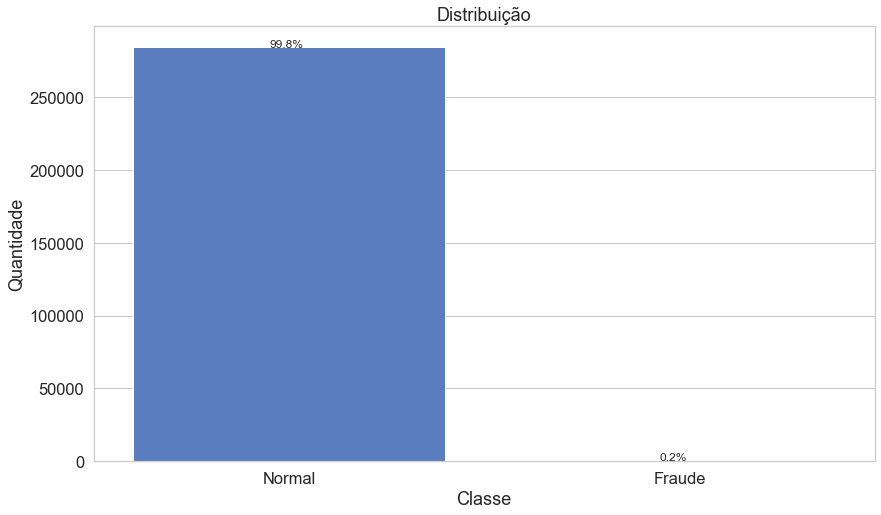

In [6]:
qtd_class = pd.value_counts(df['Class'], sort = True)
plt.title("Distribuição")
ax = sns.barplot(x=qtd_class.keys(), y=qtd_class.values)

for p in ax.patches:
    percent = '{:.1f}%'.format(100 * p.get_height()/len(df))
    x = p.get_x() + p.get_width() / 2 - 0.05
    y = p.get_y() + p.get_height()
    ax.annotate(percent, (x, y), size=12)

ax.set_xticks(range(len(LABELS)), LABELS)
ax.set_xlabel("Classe")
ax.set_ylabel("Quantidade")
plt.show()

Vamos criar uma coluna de data/tempo para poder colocar nososs registros dentro de uma time series

In [7]:
data_base = dt.datetime(2013, 9, 1, 8, 0, 0)
data_base

datetime.datetime(2013, 9, 1, 8, 0)

In [8]:
df['Data'] = df['Time'].apply(lambda x: data_base + dt.timedelta(seconds=x))

In [9]:
df['Data']

0        2013-09-01 08:00:00
1        2013-09-01 08:00:00
2        2013-09-01 08:00:01
3        2013-09-01 08:00:01
4        2013-09-01 08:00:02
                 ...        
284802   2013-09-03 07:59:46
284803   2013-09-03 07:59:47
284804   2013-09-03 07:59:48
284805   2013-09-03 07:59:48
284806   2013-09-03 07:59:52
Name: Data, Length: 284807, dtype: datetime64[ns]

In [10]:
normal = df[df['Class'] == 0].copy()
fraude = df[df['Class'] == 1].copy()

In [11]:
print('Quantidade de registros normais: ', len(df[df['Class'] == 0]))
print('Quantidade de registros fraldados: ', len(df[df['Class'] == 1]))

Quantidade de registros normais:  284315
Quantidade de registros fraldados:  492


Vamos visualizar a distribuição dos dados

In [12]:
df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,1.168375e-15,3.416908e-16,-1.379537e-15,2.074095e-15,9.604066e-16,1.487313e-15,-5.556467e-16,1.213481e-16,-2.406331e-15,...,1.654067e-16,-3.568593e-16,2.578648e-16,4.473266e-15,5.340915e-16,1.683437e-15,-3.660091e-16,-1.227390e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


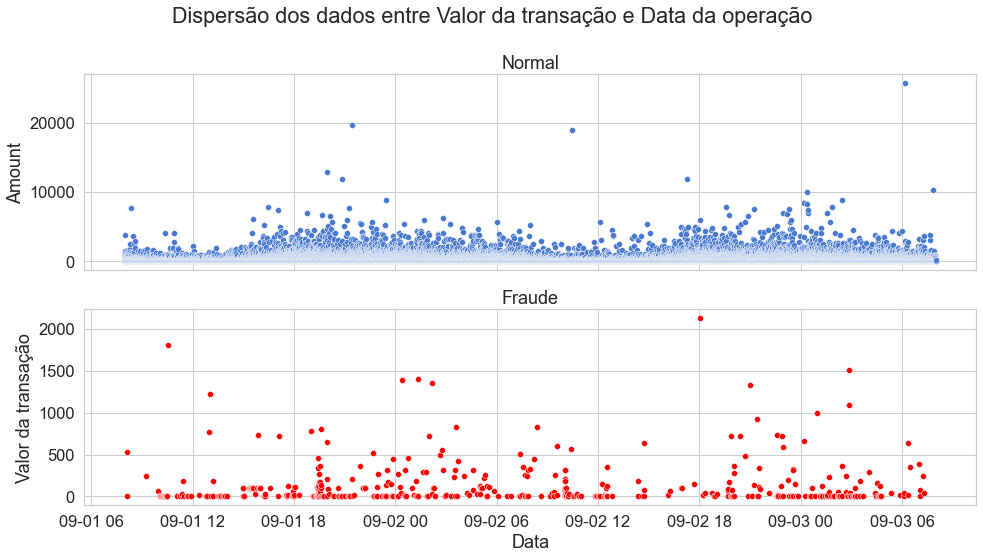

In [13]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex = True)
plt.suptitle('Dispersão dos dados entre Valor da transação e Data da operação')

ax1.set_title('Normal')
sns.scatterplot(data=normal, x='Data', y='Amount', ax=ax1)

ax2.set_title('Fraude')
sns.scatterplot(data=fraude, x='Data', y='Amount', ax=ax2, color='red')

plt.xlabel('Data')
plt.ylabel('Valor da transação')
plt.tight_layout()
plt.show()

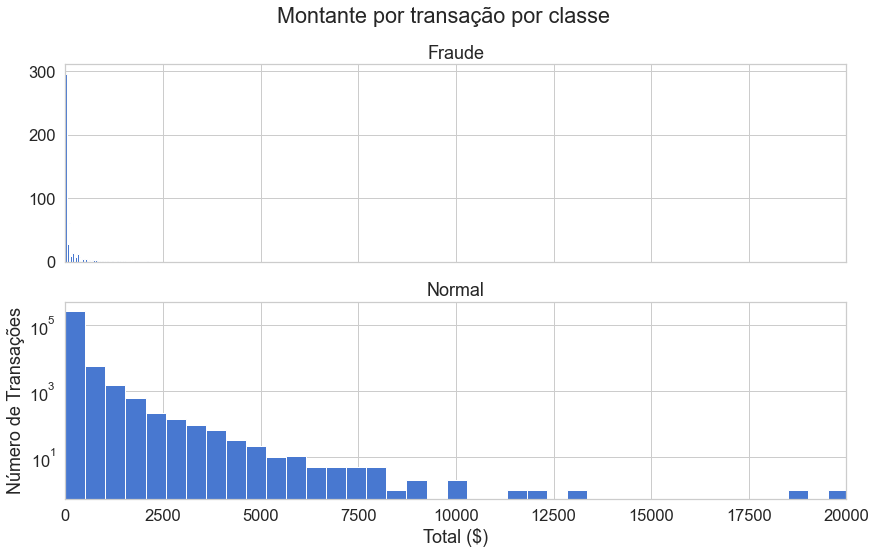

In [14]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex = True)
f.suptitle('Montante por transação por classe')

bins = 50

ax1.hist(fraude['Amount'], bins = bins)
ax1.set_title('Fraude')

ax2.hist(normal['Amount'], bins = bins)
ax2.set_title('Normal')

plt.xlabel('Total ($)')
plt.ylabel('Número de Transações')
plt.xlim((0, 20000))
plt.yscale('log')
plt.show()

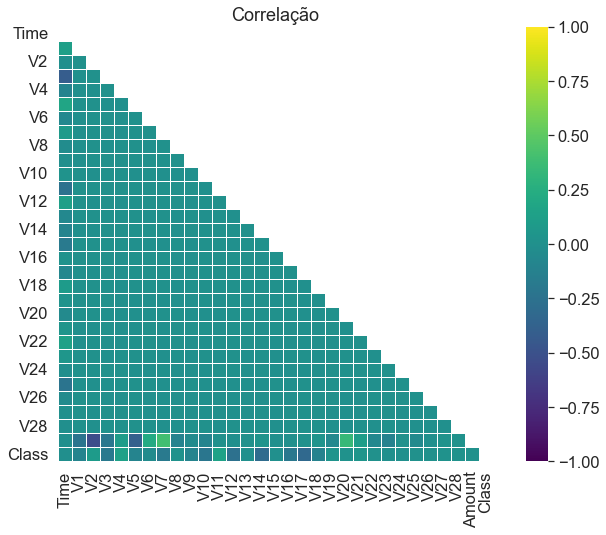

In [15]:
plt.figure(figsize=(12,8))
plt.title('Correlação')

mask = np.zeros_like(df.corr(), dtype=np.bool8)
mask[np.triu_indices_from(mask)]= True


sns.heatmap(df.corr(), mask=mask, square=True, linewidths=0.5, cmap='viridis', vmin=-1, vmax=1, annot_kws={'size': 12})
plt.show()

In [16]:
CORR = .35

In [17]:
corr_matrix = df.drop(columns=['Class', 'Time', 'Data']).corr().abs()

sol = (corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool8))
                  .unstack()
                  .sort_values(ascending=False))
col_corr = list(map(lambda x: x[1], sol[sol.values > CORR].keys()))
print('Colunas com correlação > {} %'.format(CORR), col_corr)

Colunas com correlação > 0.35 % ['V2', 'V7', 'V5']


Podemos notar que não existe uma correlação forte entre os dados.

## Modelagem dos dados


Vamos remover a informação de `Time, Class e Data` do dataset pois esses features não serão utilizadas na previsão e vamos precisar padronizar o valor de `Amount` para que não haja diferença de escala com base nos outros valores das demais features

In [18]:
scaler = StandardScaler()
scaler.fit(df['Amount'].values.reshape(-1, 1))

normal['Amount'] = scaler.transform(normal['Amount'].values.reshape(-1,1))
fraude['Amount'] = scaler.transform(fraude['Amount'].values.reshape(-1,1))

y_normal = normal['Class'].values
y_fraude = normal['Class'].values

In [19]:
normal.drop(columns=['Class', 'Time', 'Data'], inplace=True)
fraude.drop(columns=['Class', 'Time', 'Data'], inplace=True)

## Arquitetura do modelo

Nosso dataset possui duas classes: Transação `Normal` e Transação com `Fraude`, no entanto essas classes possuem um desbalanceamento muito grande. Criar um modelo preditivo para classificação, com base em aprendizado supervisionado, não conseguirá identificar as caracteristicas da classe minoritária.

Vamos utilizar um modelo baseado em Autoencoders, com aprendizado não-supervisioinado, para aprender as caracteristicas de transações normais e vamos utilizar do processo de reconstrução para identificar os registros com anomalias, uma vez que os registros com `Fraude` terão um erro de reconstrução maior devido ao modelo não "conhecer" essas caracteristicas que o definem como fraldulento.

!['Autoencoder'](./images/autoencoders.png)

<!-- Vamos utilizar junto ao autoencoder a arquitetura de LSTM para aprender sobre os dados ao passar do tempo.

!['LSTM](./images/LSTM.png)-->

Vamos dividir os dados em treino e teste para criar nosso modelo. Como vamos criar um modelo baseado em `autoencoders` e aprender as caracteristicas das transações válidas, vamos filtrar primeiramente apenas os registros com a classe `Normal` e dividi-los em sub-amostragens para treino e teste. Os registros com classe `Fraude` serão utilizadas apenas no processo de teste.

In [20]:
min_scaler = MinMaxScaler((-1,1))

normal_drop = normal.drop(columns=col_corr)
fraude_drop = fraude.drop(columns=col_corr)

#normal_min = pd.DataFrame(min_scaler.fit_transform(normal_drop), columns=normal_drop.columns)
#fraude_min = pd.DataFrame(min_scaler.transform(fraude_drop), columns=fraude_drop.columns)

In [21]:
train, test = train_test_split(normal_drop, test_size=0.2, random_state=RANDOM_SEED)
test = pd.concat([test, fraude_drop])

train = train.iloc[np.random.permutation(len(train))]
test = test.iloc[np.random.permutation(len(test))]

In [22]:
print('Treino: ', train.shape)
print('Test: ', test.shape)

Treino:  (227452, 26)
Test:  (57355, 26)


In [23]:
features = len(train.columns)
print(features)

26


### Definição do modelo

Vamos definir nosso modelo inicialmente criando a camada de encoder e posterior a camanda de decoder.

In [24]:
tf.keras.backend.clear_session()

In [25]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [26]:
input_shape = (features,)
print(input_shape)

(26,)


In [27]:
encoder = Sequential([
    Dense(24, activation='selu', input_shape=input_shape),
    Dense(12, activation='selu'),
    Dense(6, activation='selu'),
], name='encoding')

decoder = Sequential([
    Dense(6, activation='selu'),
    Dense(12, activation='selu'),
    Dense(24, activation='selu'),
    Dense(train.shape[1], activation='linear')
], name='decoding')

In [28]:
model = Sequential([encoder, decoder], name='autoencoder')

In [29]:
model.compile(optimizer = Adam(learning_rate=0.01), loss = 'mean_squared_error', metrics=['accuracy'])

In [30]:
model.summary()

Model: "autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoding (Sequential)       (None, 6)                 1026      
                                                                 
 decoding (Sequential)       (None, 26)                1088      
                                                                 
Total params: 2,114
Trainable params: 2,114
Non-trainable params: 0
_________________________________________________________________


In [31]:
encoder.summary(), decoder.summary()

Model: "encoding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 24)                648       
                                                                 
 dense_1 (Dense)             (None, 12)                300       
                                                                 
 dense_2 (Dense)             (None, 6)                 78        
                                                                 
Total params: 1,026
Trainable params: 1,026
Non-trainable params: 0
_________________________________________________________________
Model: "decoding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 6)                 42        
                                                                 
 dense_4 (Dense)             (None, 12

(None, None)

In [32]:
rp = ReduceLROnPlateau(monitor='val_loss', mode='min', patience=10, min_lr=0.001, factor=0.05)

In [33]:
cp = ModelCheckpoint('./model/autoencoders.h5', monitor='val_loss', save_best_only=True, mode='min', verbose=1)

In [34]:
es = EarlyStopping(monitor='val_loss', patience=5, mode='min')

In [35]:
with tf.device('/GPU:0'):
    history = model.fit(train, train, batch_size=256, validation_split=0.3, epochs=200, callbacks=[cp, rp])

Epoch 1/200
617/622 [============================>.] - ETA: 0s - loss: 0.4276 - accuracy: 0.5837
Epoch 1: val_loss improved from inf to 0.33497, saving model to ./model\autoencoders.h5
622/622 [==============================] - 4s 6ms/step - loss: 0.4266 - accuracy: 0.5842 - val_loss: 0.3350 - val_accuracy: 0.6330 - lr: 0.0100
Epoch 2/200
619/622 [============================>.] - ETA: 0s - loss: 0.3112 - accuracy: 0.6304
Epoch 2: val_loss improved from 0.33497 to 0.29194, saving model to ./model\autoencoders.h5
622/622 [==============================] - 3s 6ms/step - loss: 0.3116 - accuracy: 0.6303 - val_loss: 0.2919 - val_accuracy: 0.6305 - lr: 0.0100
Epoch 3/200
617/622 [============================>.] - ETA: 0s - loss: 0.2774 - accuracy: 0.6377
Epoch 3: val_loss improved from 0.29194 to 0.26310, saving model to ./model\autoencoders.h5
622/622 [==============================] - 3s 6ms/step - loss: 0.2773 - accuracy: 0.6376 - val_loss: 0.2631 - val_accuracy: 0.6377 - lr: 0.0100
Epoch

### Avaliando o treinamento do modelo

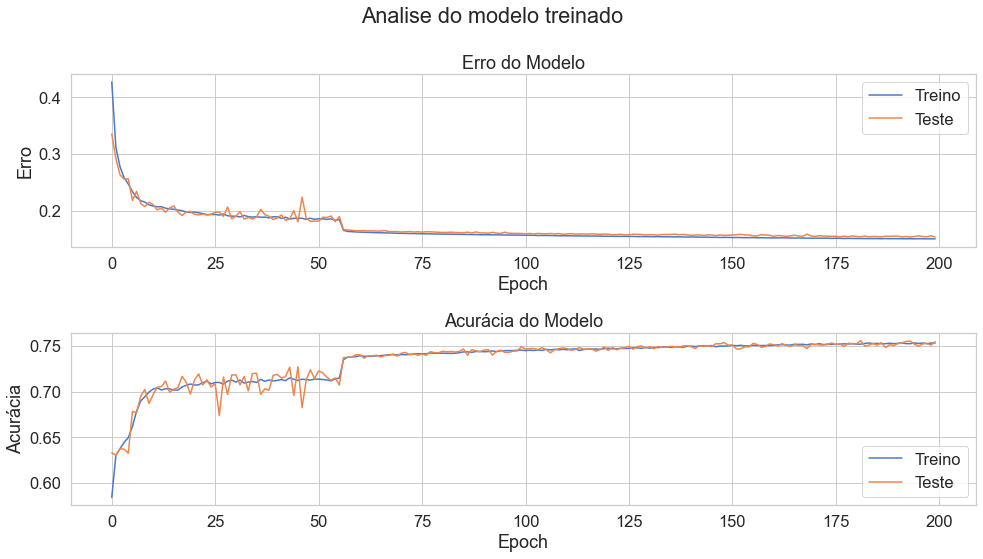

In [36]:
plt.suptitle('Analise do modelo treinado')

plt.subplot(211)
plt.title('Erro do Modelo')
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('Erro')
plt.xlabel('Epoch')
plt.legend(['Treino', 'Teste'], loc = 'best')

plt.subplot(212)
plt.title('Acurácia do Modelo')
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylabel('Acurácia')
plt.xlabel('Epoch')
plt.legend(['Treino', 'Teste'], loc = 'best')

plt.tight_layout()
plt.show()

### Carregando o modelo treinado

In [37]:
model = tf.keras.models.load_model('./model/autoencoders.h5') 

### Executando o modelo para prever as classes de testes

In [38]:
test_pred = model.predict(test)

Vamos identificar agora o erro da reconstrução gerada pelo modelo. O erro de reconstrução vai ser utilizado para prever a probabilidade de uma amostra ser uma instância fraudada. 

O fato de termos utilizado apenas registros `normais` para o treinamento do modelo do autoencoder é que durante o processo de inferência os registros com fraude perde as caracteristicas da fraude e o decodificador as reconstroi como sendo um registro normal, resultando em um grande erro de reconstrução.

Depois de calcular todos os erros no dataset de teste podemos gerar uma probabilidade, entre 0 e 1, indicando o percentual de anômalia que essa instancia possui. Com base nisso, podemos definir um threshold para limitar quais registros são anômalos.

### Função de calculo de erro para reconstrução

Vamos utilizar o erro quadrático médio para achar o erro de reconstrução do modelo.

$$\textstyle L(x,x') = ||\, x - x'||^2$$

In [39]:
labels_pred = np.mean(np.power(test-test_pred, 2), axis=1)
labels = df.iloc[test.index]['Class'].values

In [40]:
labels_pred = np.array(labels_pred).reshape(-1,1)

In [41]:
labels_pred[0:5]

array([[0.10220845],
       [0.02045651],
       [0.05442466],
       [0.05445299],
       [0.10748918]])

Vamos normalizar os erros para eles ficarem em uma mesma escala

In [42]:
erro_scaler = MinMaxScaler()
previsao_fraude = erro_scaler.fit_transform(labels_pred).flatten()

In [43]:
previsao_fraude[0:5]

array([4.93596501e-04, 7.41381467e-05, 2.48424211e-04, 2.48569589e-04,
       5.20691237e-04])

In [44]:
true_labels = [i for i, label in enumerate(labels) if label == 1]

print(labels[true_labels[0:5]])
print(previsao_fraude[true_labels[0:5]])

[1 1 1 1 1]
[0.00050917 0.01868599 0.00031602 0.00675931 0.00502301]


Vamos verificar agora se o modelo foi capaz de identificar com sucesso as anomalias nas transações.

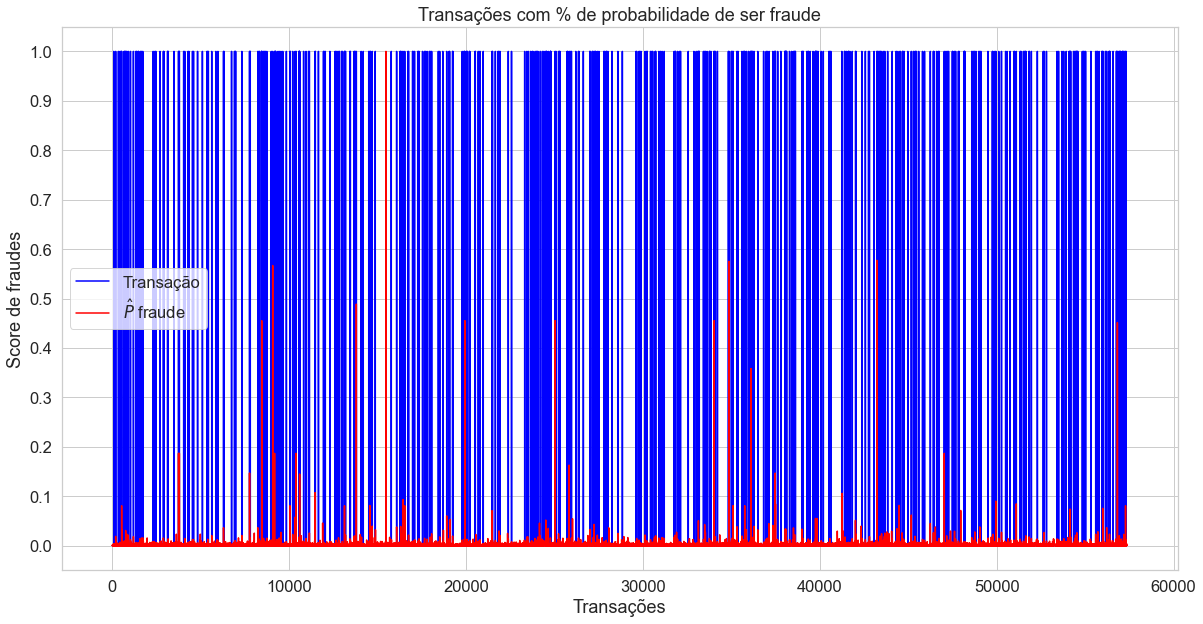

In [45]:
plt.figure(figsize=(20,10))
plt.title('Transações com % de probabilidade de ser fraude')
plt.plot(labels, c='blue', label='Transação')
plt.plot(previsao_fraude, c='red', label='$\hat{P}$ fraude')
plt.yticks(np.arange(0, 1.1, 0.1))
plt.xlabel('Transações')
plt.ylabel('Score de fraudes')
plt.legend()
plt.show()

## Avaliação do modelo

Vamos avaliar agora se o nosso modelo teve uma boa taxa de acerto nos dados de testes. Vamos utilizar a curva ROC-AUC para medir a eficácia de nosso modelo em distingir as duas classes. 

Valores perto do canto superior esquerdo, perto de 1, indicam que o classificar é bom em distinguir as classes e valores abaixo da área média, perto de 0.5, indicam que o modelo não conseguiu distinguir entre as classes.

In [46]:
fpr, tpr, threshold = roc_curve(labels, previsao_fraude)

In [47]:
score_auc = roc_auc_score(labels, previsao_fraude)
print('Score AUC: ', score_auc)

Score AUC:  0.945658971520338


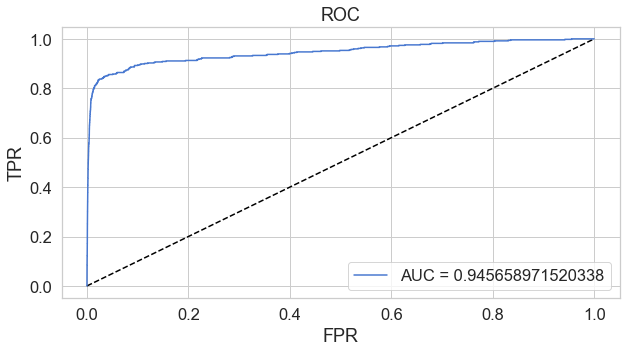

In [48]:
plt.figure(figsize = (10,5))
plt.title('ROC')
plt.plot([0, 1], [0, 1], color = 'black', linestyle = '--')
plt.plot(fpr, tpr, label = 'AUC = {}'.format(score_auc))
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend()
plt.show()

Nosso modelo conseguiu classificar bem os eventos com transações anômalas. Porém como temos dados desbalanceados o ROC pode não expressar corretamente o quao bom ou ruim esta nosso modelo. Vamos utilizar para isso outras métricas de avaliação.

## Precisão vs Recal

!['Precisao vs Recall'](./images/precision_recall.png)

Precisão e Recall são métricas para avaliar o quanto um modelo esta conseguindo identificar as classes corretas durante um processo de classificação. Porém a precisão e o recall tem objetivos distintos na identificação do quão bem o modelo esta classificando.

Precisão e recall são definidos da seguinte forma:

$$\text{Precision} = \frac{\text{true positives}}{\text{true positives} + \text{false positives}}$$

$$\text{Recall} = \frac{\text{true positives}}{\text{true positives} + \text{false negatives}}$$

* A precisão mede a relevância dos resultados obtidos. 

* Recall, por outro lado, mede quantos resultados relevantes são retornados.

Ambos os valores podem ter valores entre 0 e 1.

Vamos calcular agora os valores e plotar em um gráfico

In [49]:
precision, recall, th = precision_recall_curve(labels, previsao_fraude)

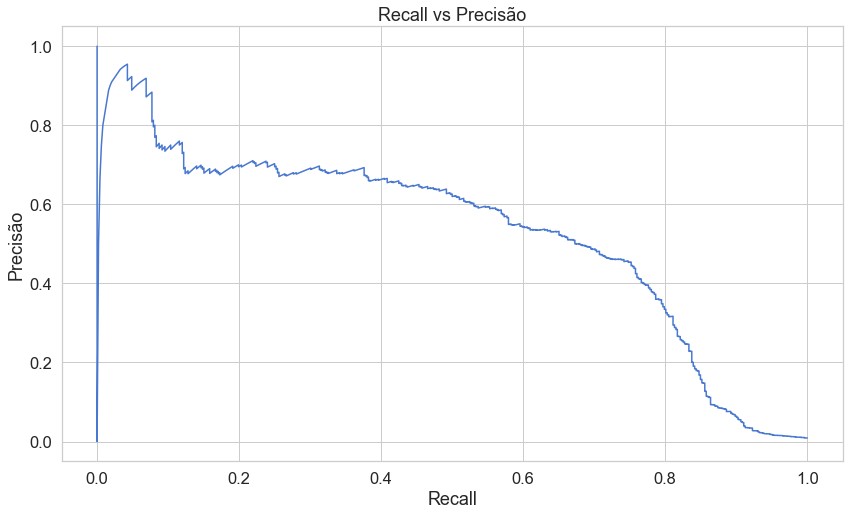

In [50]:
plt.title('Recall vs Precisão')
plt.plot(recall, precision, 'b', label = 'Curva Precisão-Recall')
plt.xlabel('Recall')
plt.ylabel('Precisão')
plt.show()

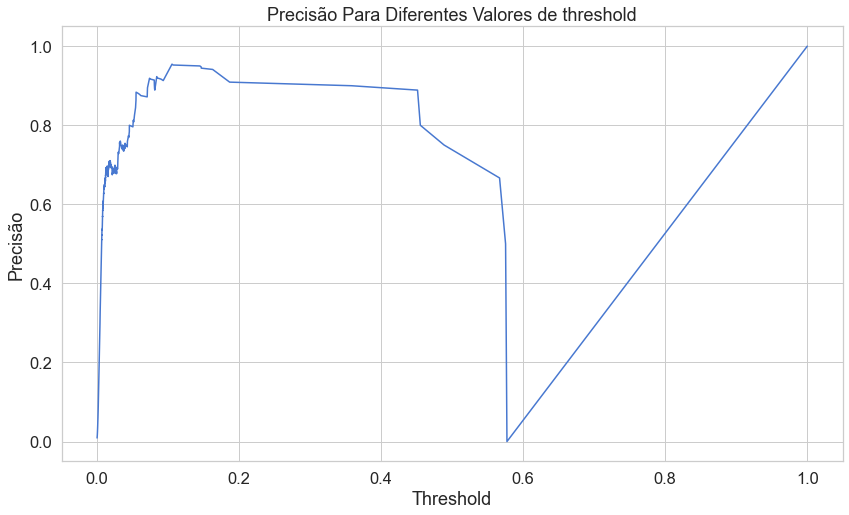

In [51]:
plt.plot(th, precision[1:], 'b', label = 'Curva Threshold-Precisão')
plt.title('Precisão Para Diferentes Valores de threshold')
plt.xlabel('Threshold')
plt.ylabel('Precisão')
plt.show()

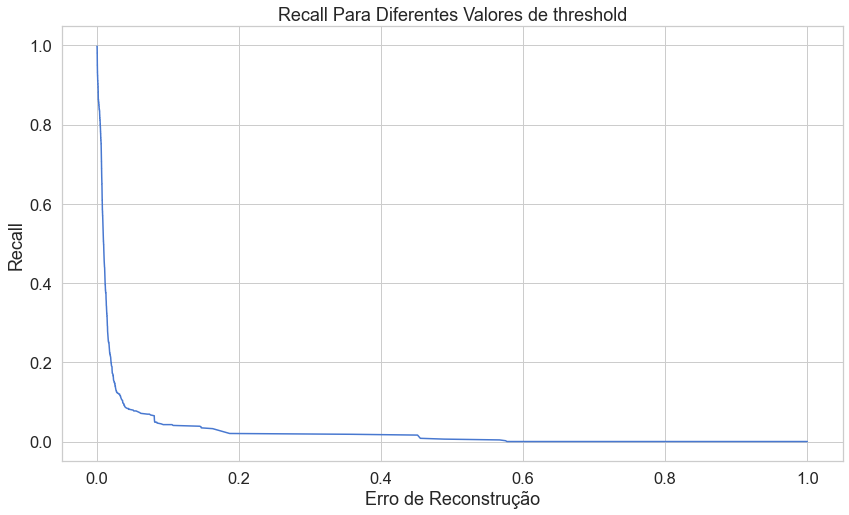

In [52]:
plt.plot(th, recall[1:], 'b', label = 'Curva Threshold-Recall')
plt.title('Recall Para Diferentes Valores de threshold')
plt.xlabel('Erro de Reconstrução')
plt.ylabel('Recall')
plt.show()

## Identificando fraudes

Precisamos agora definir um limite de threshold para o nosso modelo. Valores acima desse limite indicaram que os registros possuem fraude na transação, então precisamos achar um valor que consiga identificar o maior número possível de fraudes.

Vamos utilizar como base a métrica de F1-Score, que é uma média harmônica de precisão e recall.

In [53]:
limites_fraude = [(previsao_fraude > i).astype(np.int32) for i in threshold]
f1_scores = [f1_score(labels, i) for i in limites_fraude]

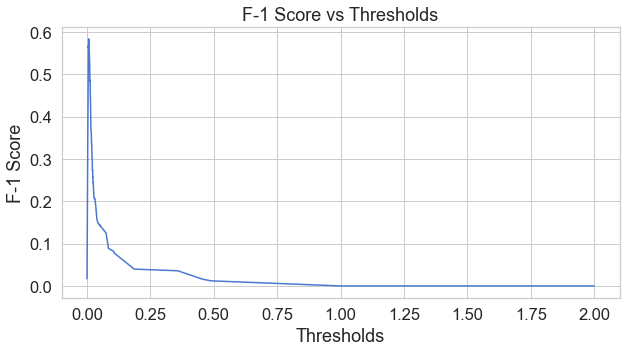

In [54]:
plt.figure(figsize = (10, 5))
plt.title('F-1 Score vs Thresholds')
plt.plot(threshold, f1_scores)
plt.xlabel('Thresholds')
plt.ylabel('F-1 Score')
plt.show()

Vamos obter o melhor threshold

In [55]:
melhor_threshold = threshold[f1_scores.index(np.max(f1_scores))]
print('Melhor Threshold = {}'.format(melhor_threshold))

Melhor Threshold = 0.006936865985364896


Vamos agora classificar nossos registros com base nesse threshold

In [56]:
indicador_fraude = (previsao_fraude > melhor_threshold).astype(np.int32)

In [57]:
indicador_fraude

array([0, 0, 0, ..., 0, 0, 0])

Vamos analisar agora como ficou as classificações dos registros com base no threshold selecionado

In [58]:
confusion_matrix(labels, indicador_fraude)

array([[56581,   282],
       [  173,   319]], dtype=int64)

In [59]:
indicador_fraude_final = ['normal' if i == 0 else 'fraude' for i in indicador_fraude]

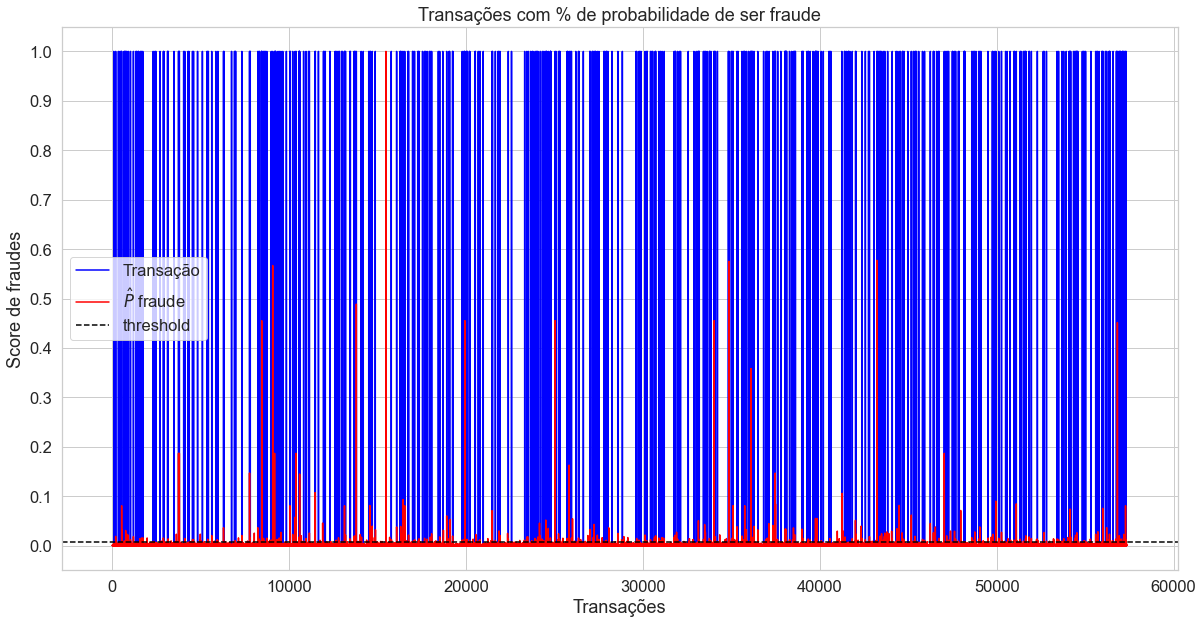

In [60]:
plt.figure(figsize=(20,10))
plt.title('Transações com % de probabilidade de ser fraude')
plt.plot(labels, c='blue', label='Transação')
plt.plot(previsao_fraude, c='red', label='$\hat{P}$ fraude')

plt.axhline(y = melhor_threshold, linestyle = '--', label = 'threshold', color='black')

plt.yticks(np.arange(0, 1.1, 0.1))
plt.xlabel('Transações')
plt.ylabel('Score de fraudes')
plt.legend()
plt.show()

## Metricas de performance

In [61]:
precision = precision_score(labels, indicador_fraude)
recall = recall_score(labels, indicador_fraude)
f1_sc = f1_score(labels, indicador_fraude)
accuracy_sc = accuracy_score(labels, indicador_fraude)

In [62]:
print('Métricas de Avaliação do Modelo:\nPrecision = {}\nRecall = {}\nScore F1 = {}\nAcurácia = {}'
      .format(precision, recall, f1_sc, accuracy_sc))

Métricas de Avaliação do Modelo:
Precision = 0.5307820299500832
Recall = 0.6483739837398373
Score F1 = 0.5837145471180236
Acurácia = 0.9920669514427687


In [63]:
print(classification_report(labels, indicador_fraude))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56863
           1       0.53      0.65      0.58       492

    accuracy                           0.99     57355
   macro avg       0.76      0.82      0.79     57355
weighted avg       0.99      0.99      0.99     57355

